In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pickle

sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

from os import walk

import copy

In [4]:
# nCMs = 9

# def grab_traces(name="baseline", verbose=False):
#     files_found = 0
#     all_traces = []
#     for i, (dirpath, dirnames, filenames) in enumerate(walk(f"cm_traces/{name}")):
#         for f in filenames:
#             if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f:
#                 if "default" in f:
#                     default_res = np.loadtxt(dirpath+"/"+f)
#                     print("Found default results.")
        
        
#         for f in filenames:
#             if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "default" not in f:
#                 trace = 100*(1-np.loadtxt(dirpath+"/"+f))

#                 files_found += 1
#                 trace_med = np.median(trace, axis=0)
#                 trace_std = np.std(trace, axis=0)
#                 f_nCMs = trace_med.shape[0]
#                 if f_nCMs > nCMs:
#                     trace_med = trace_med[:nCMs]
#                     trace_std = trace_med[:nCMs]
#                 elif f_nCMs < nCMs:
# #                     print(trace_med)
#                     leaveout_num = int(f[-5])
# #                     print(f"leavout_num is {leaveout_num}")
#                     trace_med = np.insert(trace_med, leaveout_num, np.median(default_res, axis=0)[leaveout_num])
#                     trace_std = np.insert(trace_std, leaveout_num, 0)
# #                     print(trace_med)

#                 trace_obj = copy.deepcopy((trace, trace_med, trace_std))
#                 all_traces.append(trace_obj)

#                 if verbose:
#                     print(f"Importing {f}")
                    
#     print(f"Found {files_found} tests")
#     return default_res, all_traces

# def summarise_traces(trace_info):
#     num_tests = len(trace_info)
#     all_medians = np.zeros((num_tests, nCMs))
#     all_stds = np.zeros((num_tests, nCMs))
    
#     for t in range(num_tests):
#         all_medians[t, :] = trace_info[t][1]
#         all_stds[t, :] = trace_info[t][2]
    
#     std_medians =  np.std(all_medians, axis=0)
#     std_stds =  np.std(all_stds, axis=0) 
#     return std_medians, std_stds

In [51]:
derived_features = [
 ("Mask Wearing", [1-1]),
 ("Symptomatic Testing", [2-1]),
 ("Gatherings <1000", [3-1]),
 ("Gatherings <100", [3-1, 4-1]),
 ("Gatherings <10", [3-1, 4-1, 5-1]),
 ("Some Businesses Suspended", [6-1]),
 ("Most Businesses Suspended", [6-1, 7-1]),
 ("School Closure", [8-1]),
 ("Stay Home Order", [9-1]),  
 ]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, width):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    y_vals = -1 * np.arange(nF)
    
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=8, alpha=alpha)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)

In [132]:
from collections import defaultdict

def grab_traces_categorised(name="baseline", verbose=False):
    files_found = 0
    all_traces = []
    cat_sen = defaultdict(list)
    for i, (dirpath, dirnames, filenames) in enumerate(walk(f"cm_traces/{name}")):
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "base" not in f:
                
                if "default" in f:
                    default_res = np.loadtxt(dirpath+"/"+f)
                    
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "base" not in f:
                    
                trace = np.loadtxt(dirpath+"/"+f)
                nS, f_nCMs = trace.shape
                
                if f_nCMs > nCMs:
                    trace = trace[:, :nCMs]
                elif f_nCMs < nCMs:
                    leaveout_num = int(f[-5])
                    full_trace = np.zeros((nS, nCMs))
                    full_trace[:, :leaveout_num] = trace[:, :leaveout_num]
                    full_trace[:, leaveout_num] = default_res[:, leaveout_num]
                    full_trace[:, (leaveout_num+1):] = trace[:, leaveout_num:]
                    trace = full_trace
                
                files_found += 1
                
                res = trace
                    
                if name == "additive":
                    res = 1 - res
                
                if "delay_mean_death" in f or "delay_mean_confirmed" in f or "delay_mean" in f: 
                    cat_sen["Delays"].append((f, res))
                    files_found += 1
                
                    if verbose:
                        print(f"delays added {f}")
                    
                elif "serial_int" in f: 
                    cat_sen["Serial Interval"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"si added {f}")
                    
                elif "leavout" in f: 
                    cat_sen["NPI Leaveouts"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"leavouts added {f}")
                    
                elif "prior" in f: 
                    cat_sen["Epidemiological Priors"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"epi prior {f}")
                        
                elif "noise" in f and "no_noise" not in f: 
                    cat_sen["Hyperparameter"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"hypers added {f}")
                        
                elif "regions_heldout" in f or "regholdout" in f: 
                    cat_sen["Region Holdouts"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"reg holdouts added {f}")
                    
                elif "schools" in f: 
                    cat_sen["SE Schools"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"mob added {f}")
                    
                elif "min_confirmed" in f: 
                    cat_sen["Minimum Confirmed Cases"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                
                elif "mobility" in f: 
                    cat_sen["Mobility"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                else:
                    print(f"File {f} not added - no category found")
    
    if name == "additive":
        default_res = 1-default_res
    
    return default_res, cat_sen

In [157]:
import re 

def fname_to_label(f):
    if "regholdout" in f:
        return f[:2]
    
    if "regions_heldout" in f:
        return f[16:18]
    
    if "cm_prior" in f:
        if "wide" in f:
            return "$\\alpha_i \sim \mathcal{N}(0, 10^2)$"
        
        if "half_normal" in f:
            return "$\\alpha_i \sim \mathcal{N}^+(0, 0.2^2)$"
    
    if "data_mobility" in f:
        if "no_work" in f:
            return "Retail & Recreation"
        elif "rec_work" in f:
            return "Workplace & Retail &\nRecreation"
    
    if "R_hyperprior" in f:
        if "0" in f:
            return "$\mu[R]=1.5$"
        elif "1" in f:
            return "$\mu[R]=5.5$"
    
    if "schools_open" in f:
        return "SE Schools Open"

    if "delay" in f and "confirmed" in f:
         if "0" in f:
            return "Cases: $-2$ days"
         if "1" in f:
            return "Cases: $-1$ days" 
         if "2" in f:
            return "Cases: $+1$ days" 
         if "3" in f and "v3" not in f:
            return "Cases: $+2$ days" 
    
    if "delay" in f and "death" in f:
         if "0" in f:
            return "Deaths: $-2$ days"
         if "1" in f:
            return "Deaths: $-1$ days" 
         if "2" in f:
            return "Deaths: $+1$ days" 
         if "3" in f and "v3" not in f:
            return "Deaths: $+2$ days" 

    if "cm_leavout" in f:
        if "0" in f:
            return "Mask Wearing"
        if "1" in f:
            return "Symptomatic Testing"
        if "2" in f:
            return "Gatherings <1000"
        if "3" in f and "v3" not in f:
            return "Gatherings <100"
        if "4" in f:
            return "Gatherings <10"
        if "5" in f:
            return "Some Businesses\nSuspended"
        if "6" in f:
            return "Most Businesses\nSuspended"
        if "7" in f:
            return "School Closure"
        if "8" in f:
            return "Stay at Home Order"
        
    if "serial_int" in f:
        if "SI4" in f:
            return "$\mu=4$"
        if "SI5" in f:
            return "$\mu=5$"
        if "SI6" in f:
            return "$\mu=6$"
        if "SI7" in f:
            return "$\mu=7$"
        if "SI8" in f:
            return "$\mu=8$"
    
    if "min_confirmed" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val}"
    
    if "cm_prior_combined_additive" in f:
        if "10" in f:
            return "$\\alpha_i\sim$Dirichlet($\\alpha=10$)"
        if "5" in f:
            return "$\\alpha_i\sim$Dirichlet($\\alpha=5$)"
        
    
    return f

In [158]:
def create_sensitivity_summary_plot(name):

    plt.figure(figsize=(10, 8), dpi=300)
    default_res, cat_sen = grab_traces_categorised(name)
    colors = [*sns.color_palette("bright"), *sns.color_palette("dark"), *sns.color_palette("bright"), *sns.color_palette("dark")]

    plt.subplot(3,3,1)
    nF = len(derived_features)
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([-100, 100])
    for height in range(0, nF, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="ghostwhite")

    x_min = -100
    x_max = 100
    plt.xlim([x_min, x_max])
    xtick_vals = np.arange(-100, 150, 50)
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.ylim([-(nF - 0.5), 0.5])

    plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8)
    ax = plt.gca()

    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=6)
    plt.title("Default", fontsize=10)
    add_trace_to_plot(default_res, 0, col="k", label="Default", alpha=1, width=2)        

    ks = cat_sen.keys()
    vs = cat_sen.values()
    kvs = list(zip(ks, vs))
    kvs.sort(key=lambda x: x[0])
    
    for i, (k, v) in enumerate(kvs):
        plt.subplot(3,3,i+2)

        nF = len(derived_features)
        plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
        xrange = np.array([-100, 100])
        for height in range(0, nF, 2):
            plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="ghostwhite")

        x_min = -100
        x_max = 100
        plt.xlim([x_min, x_max])
        xtick_vals = np.arange(-100, 150, 50)
        xtick_str = [f"{x:.0f}%" for x in xtick_vals]
        plt.ylim([-(nF - 0.5), 0.5])

        if i == 2 or i == 5:
            plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8)
        else:
            plt.yticks([])
        ax = plt.gca()

        x_r = np.abs(x_min - x_max)
        plt.xticks(xtick_vals, xtick_str, fontsize=6)

        if i > 2:
            plt.xlabel("Reduction in $R$", fontsize=6)

        plt.title(k, fontsize=10)
        num_vals = len(v)
        if num_vals > 3:
            width = 0.5
            y_off = np.linspace(-0.4, 0.4, len(v)+1)
        else:
            width = 1
            y_off = np.linspace(-0.2, 0.2, len(v)+1)
        
        def_label = "Default"
        
        if k == "Minimum Confirmed Cases":
            def_label += " (100)"
            
        if k == "Epidemiological Priors" and name!="additive":
            def_label += "\n($\mu[R]=3.25$,\n$\\alpha_i \sim \mathcal{N}(0, 0.2^2)$)"
        
        if k == "Epidemiological Priors" and name=="additive":
            def_label += "\n($\mu[R]=3.25$,\n$\\alpha_i \sim$Dirichlet$(\\alpha=1)$)"
        
        if k == "Serial Interval":
            def_label += " ($\mu=6.67$)"
        
        add_trace_to_plot(default_res, y_off[-1], col="k", label=def_label, alpha=1, width=width)        

    #     if k == "Region Holdouts" or k == "NPI Leaveouts":
        v.sort(key=lambda x:x[0])

        for j, (f, res) in enumerate(v):
            add_trace_to_plot(res, y_off[j], col=colors[j], label=fname_to_label(f), alpha=1, width=width)
        plt.legend(fontsize=6, loc="lower left")

    plt.tight_layout()
    plt.savefig(f"FigureSA{name}.pdf", bbox_inches='tight')

File default_combined.txt not added - no category found
File default_combined_additive.txt not added - no category found
File default_combined_v3.txt not added - no category found
File fd_conf15_deaths15_combined_v3.txt not added - no category found
File fd_conf30_deaths15_combined_v3.txt not added - no category found
File fd_conf30_deaths30_combined_v3.txt not added - no category found
File fd_conf15_deaths30_combined_v3.txt not added - no category found
File default_combined_dif.txt not added - no category found
File default_combined_icl_no_noise.txt not added - no category found
File default_combined_icl.txt not added - no category found


[None, None, None, None, None, None]

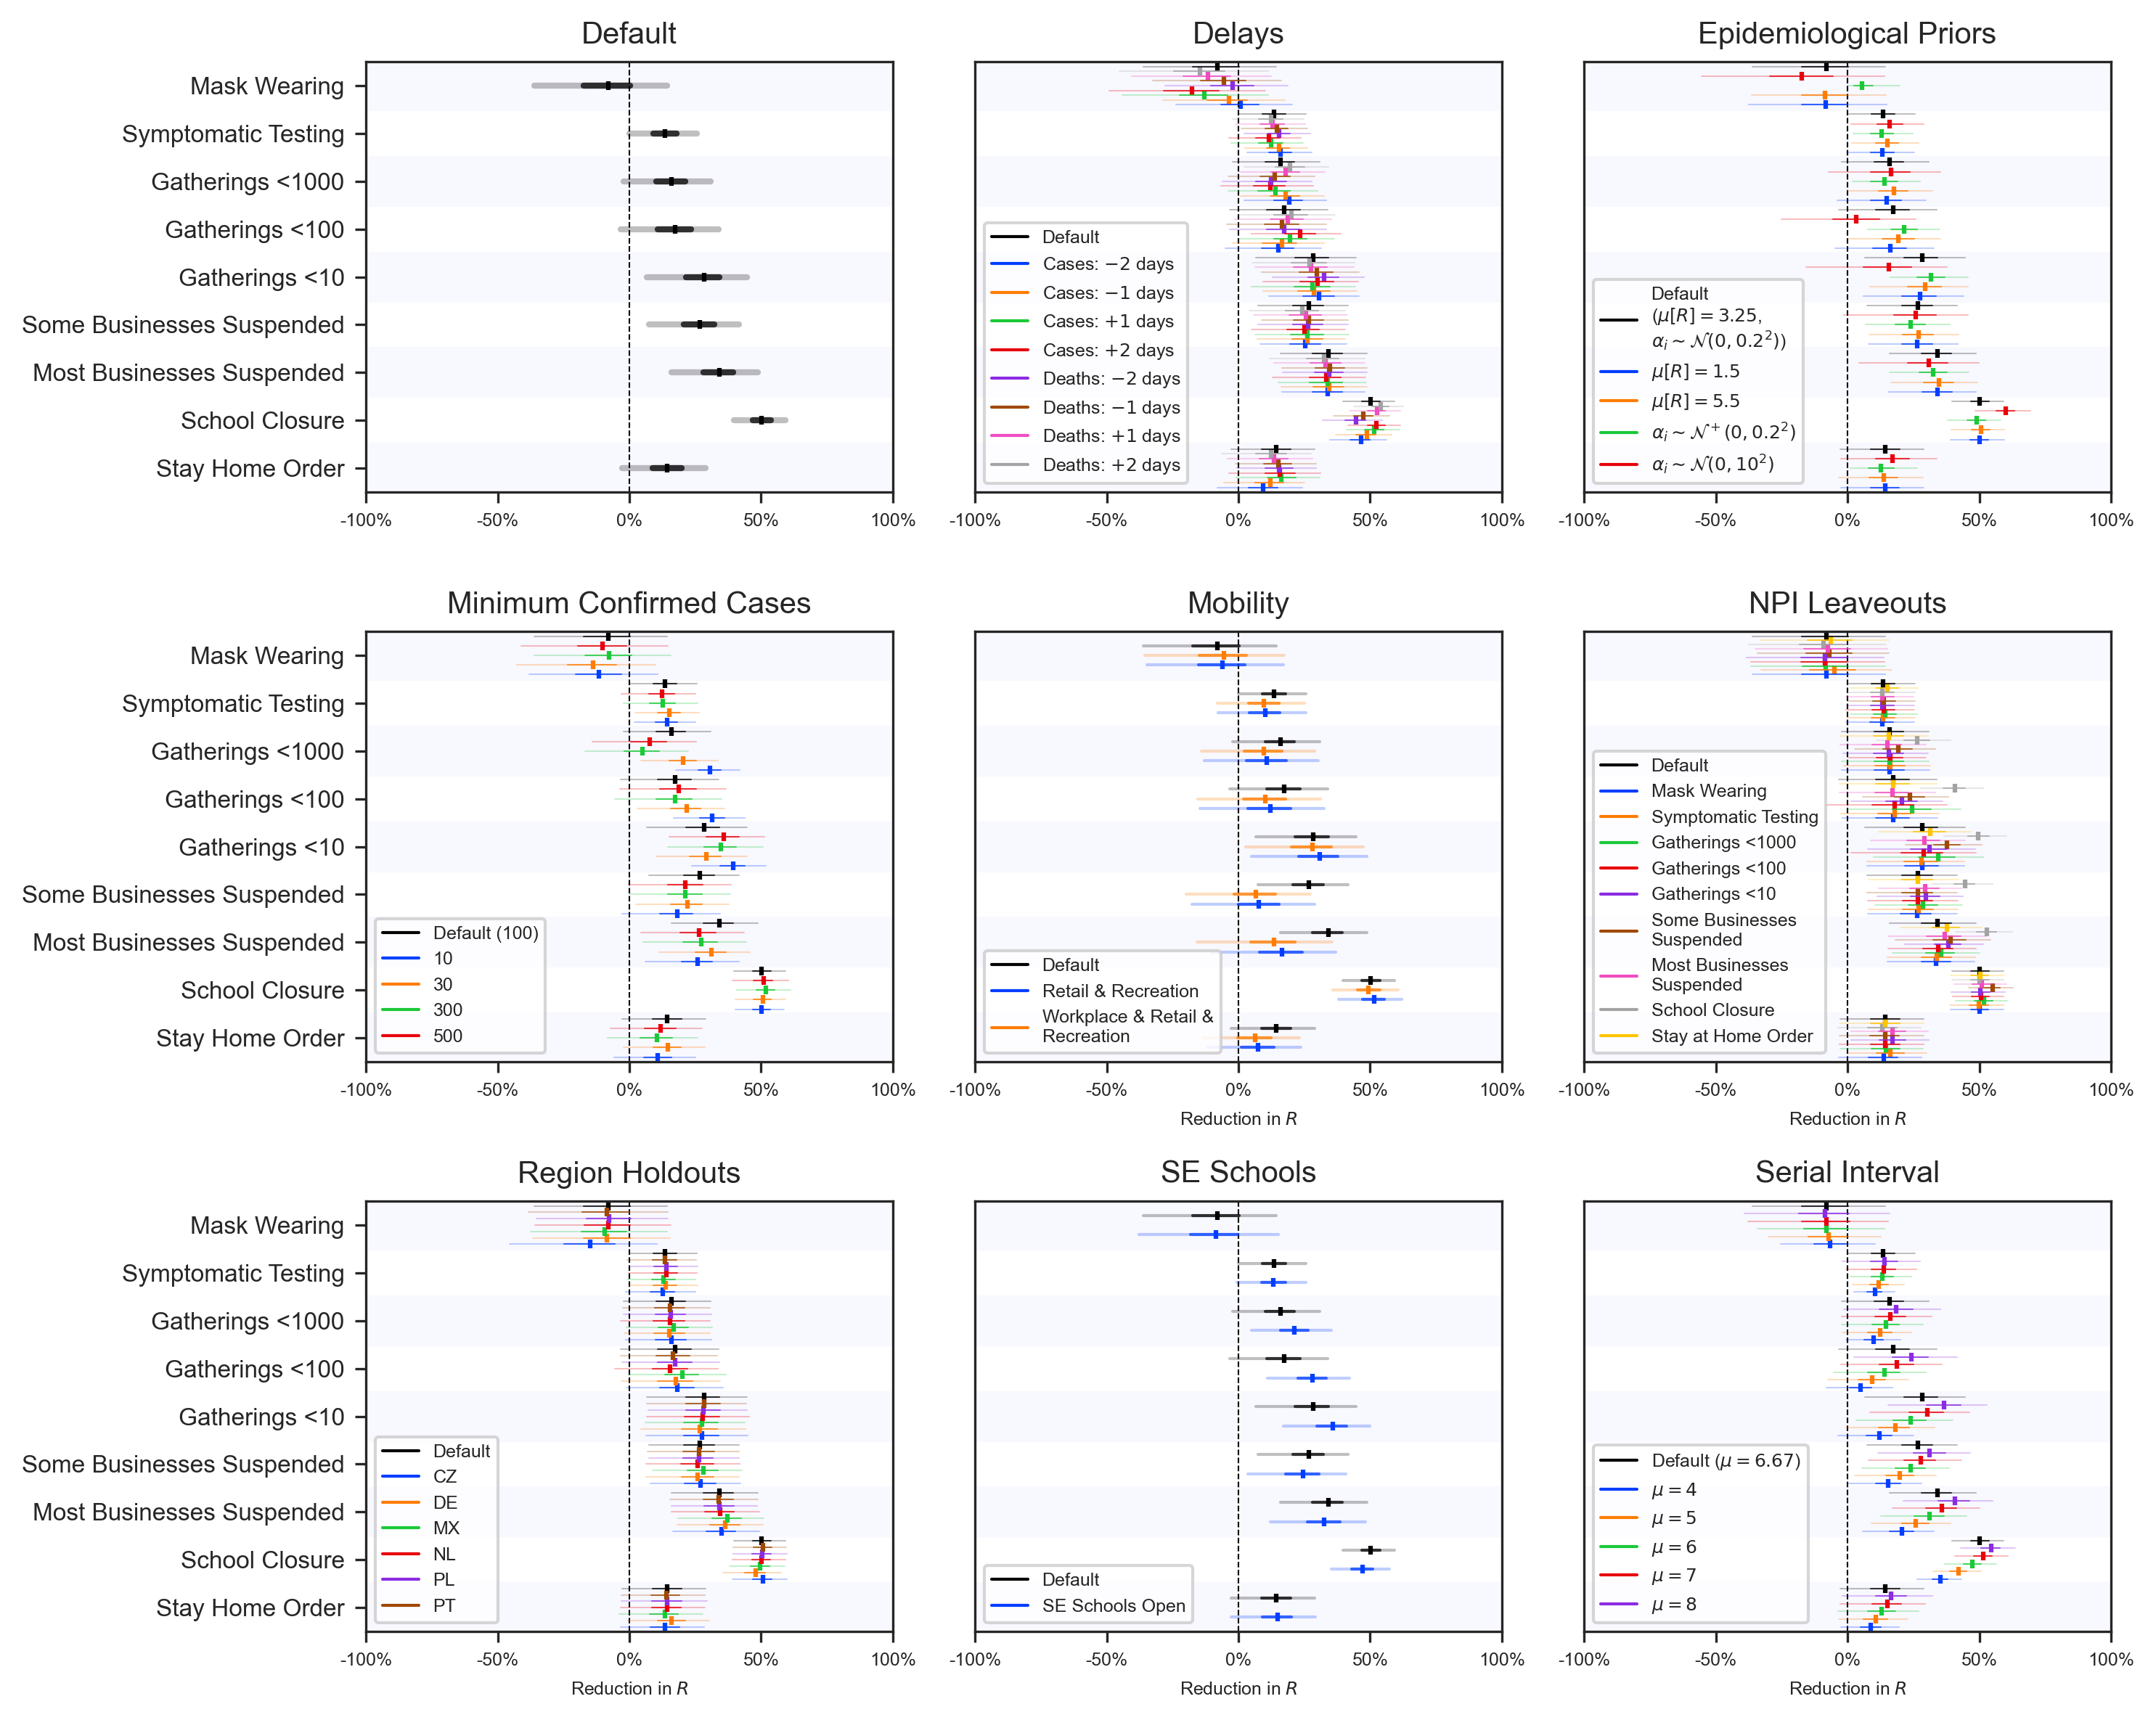

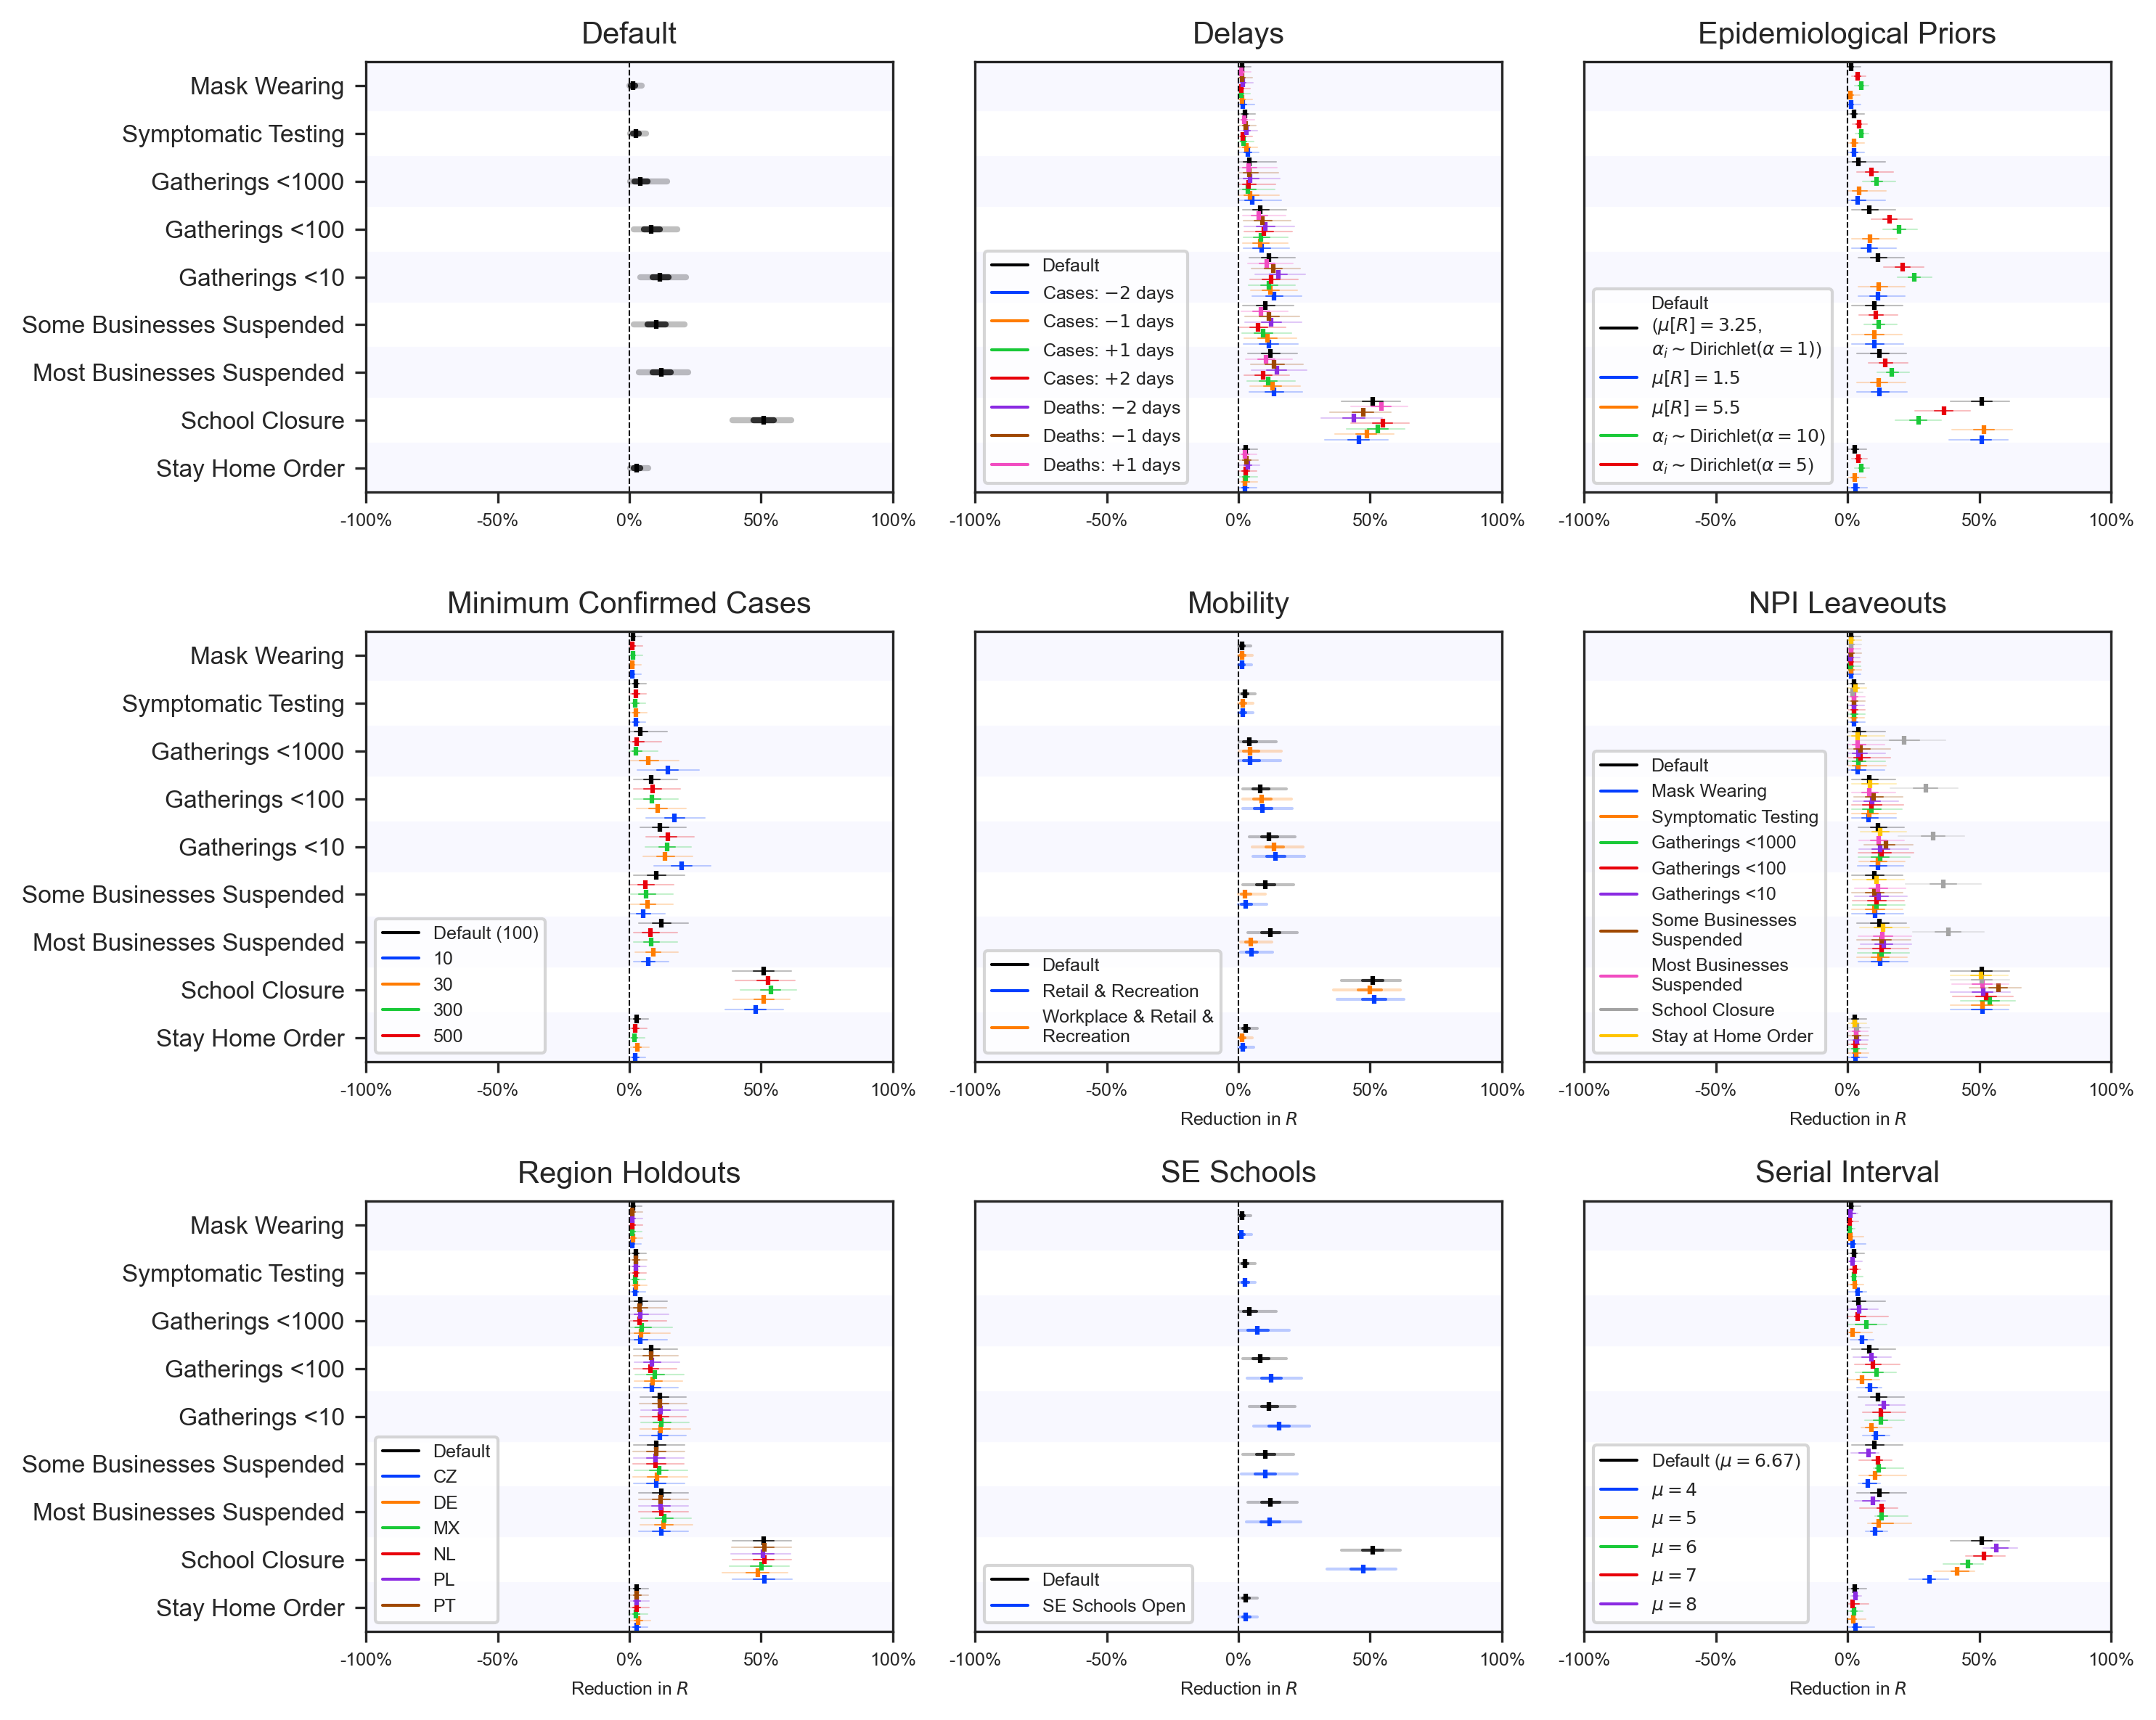

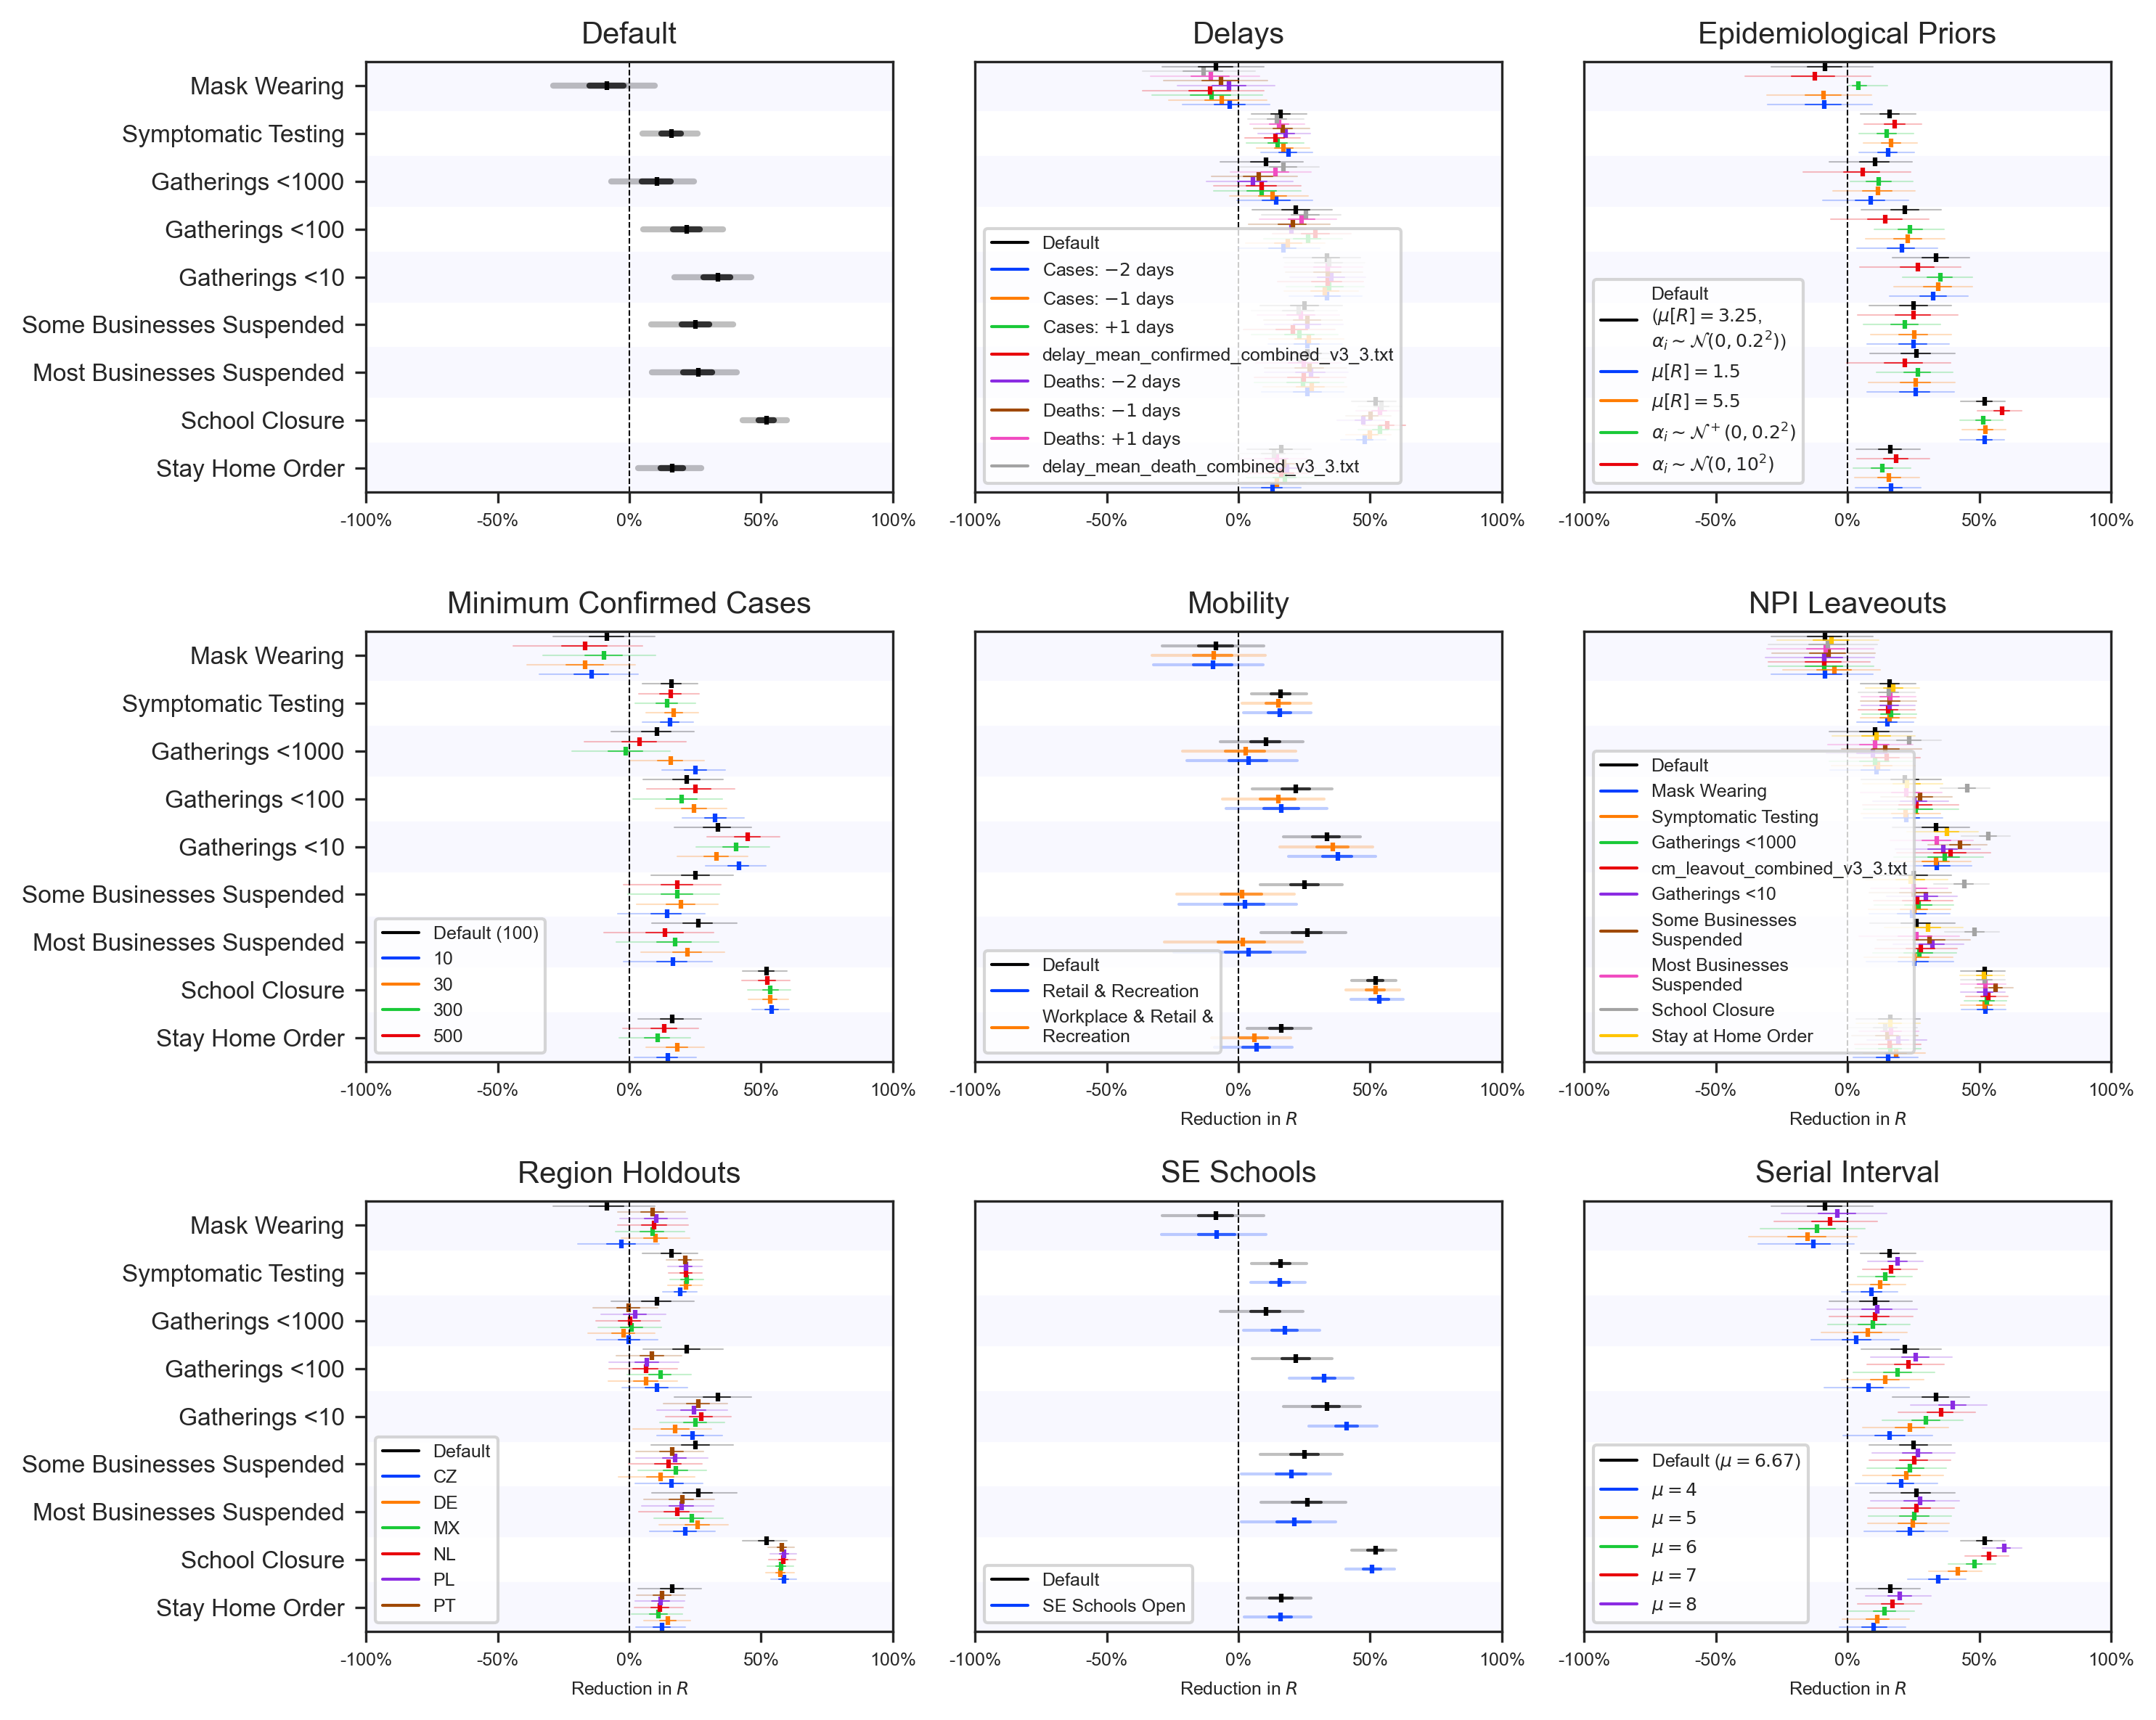

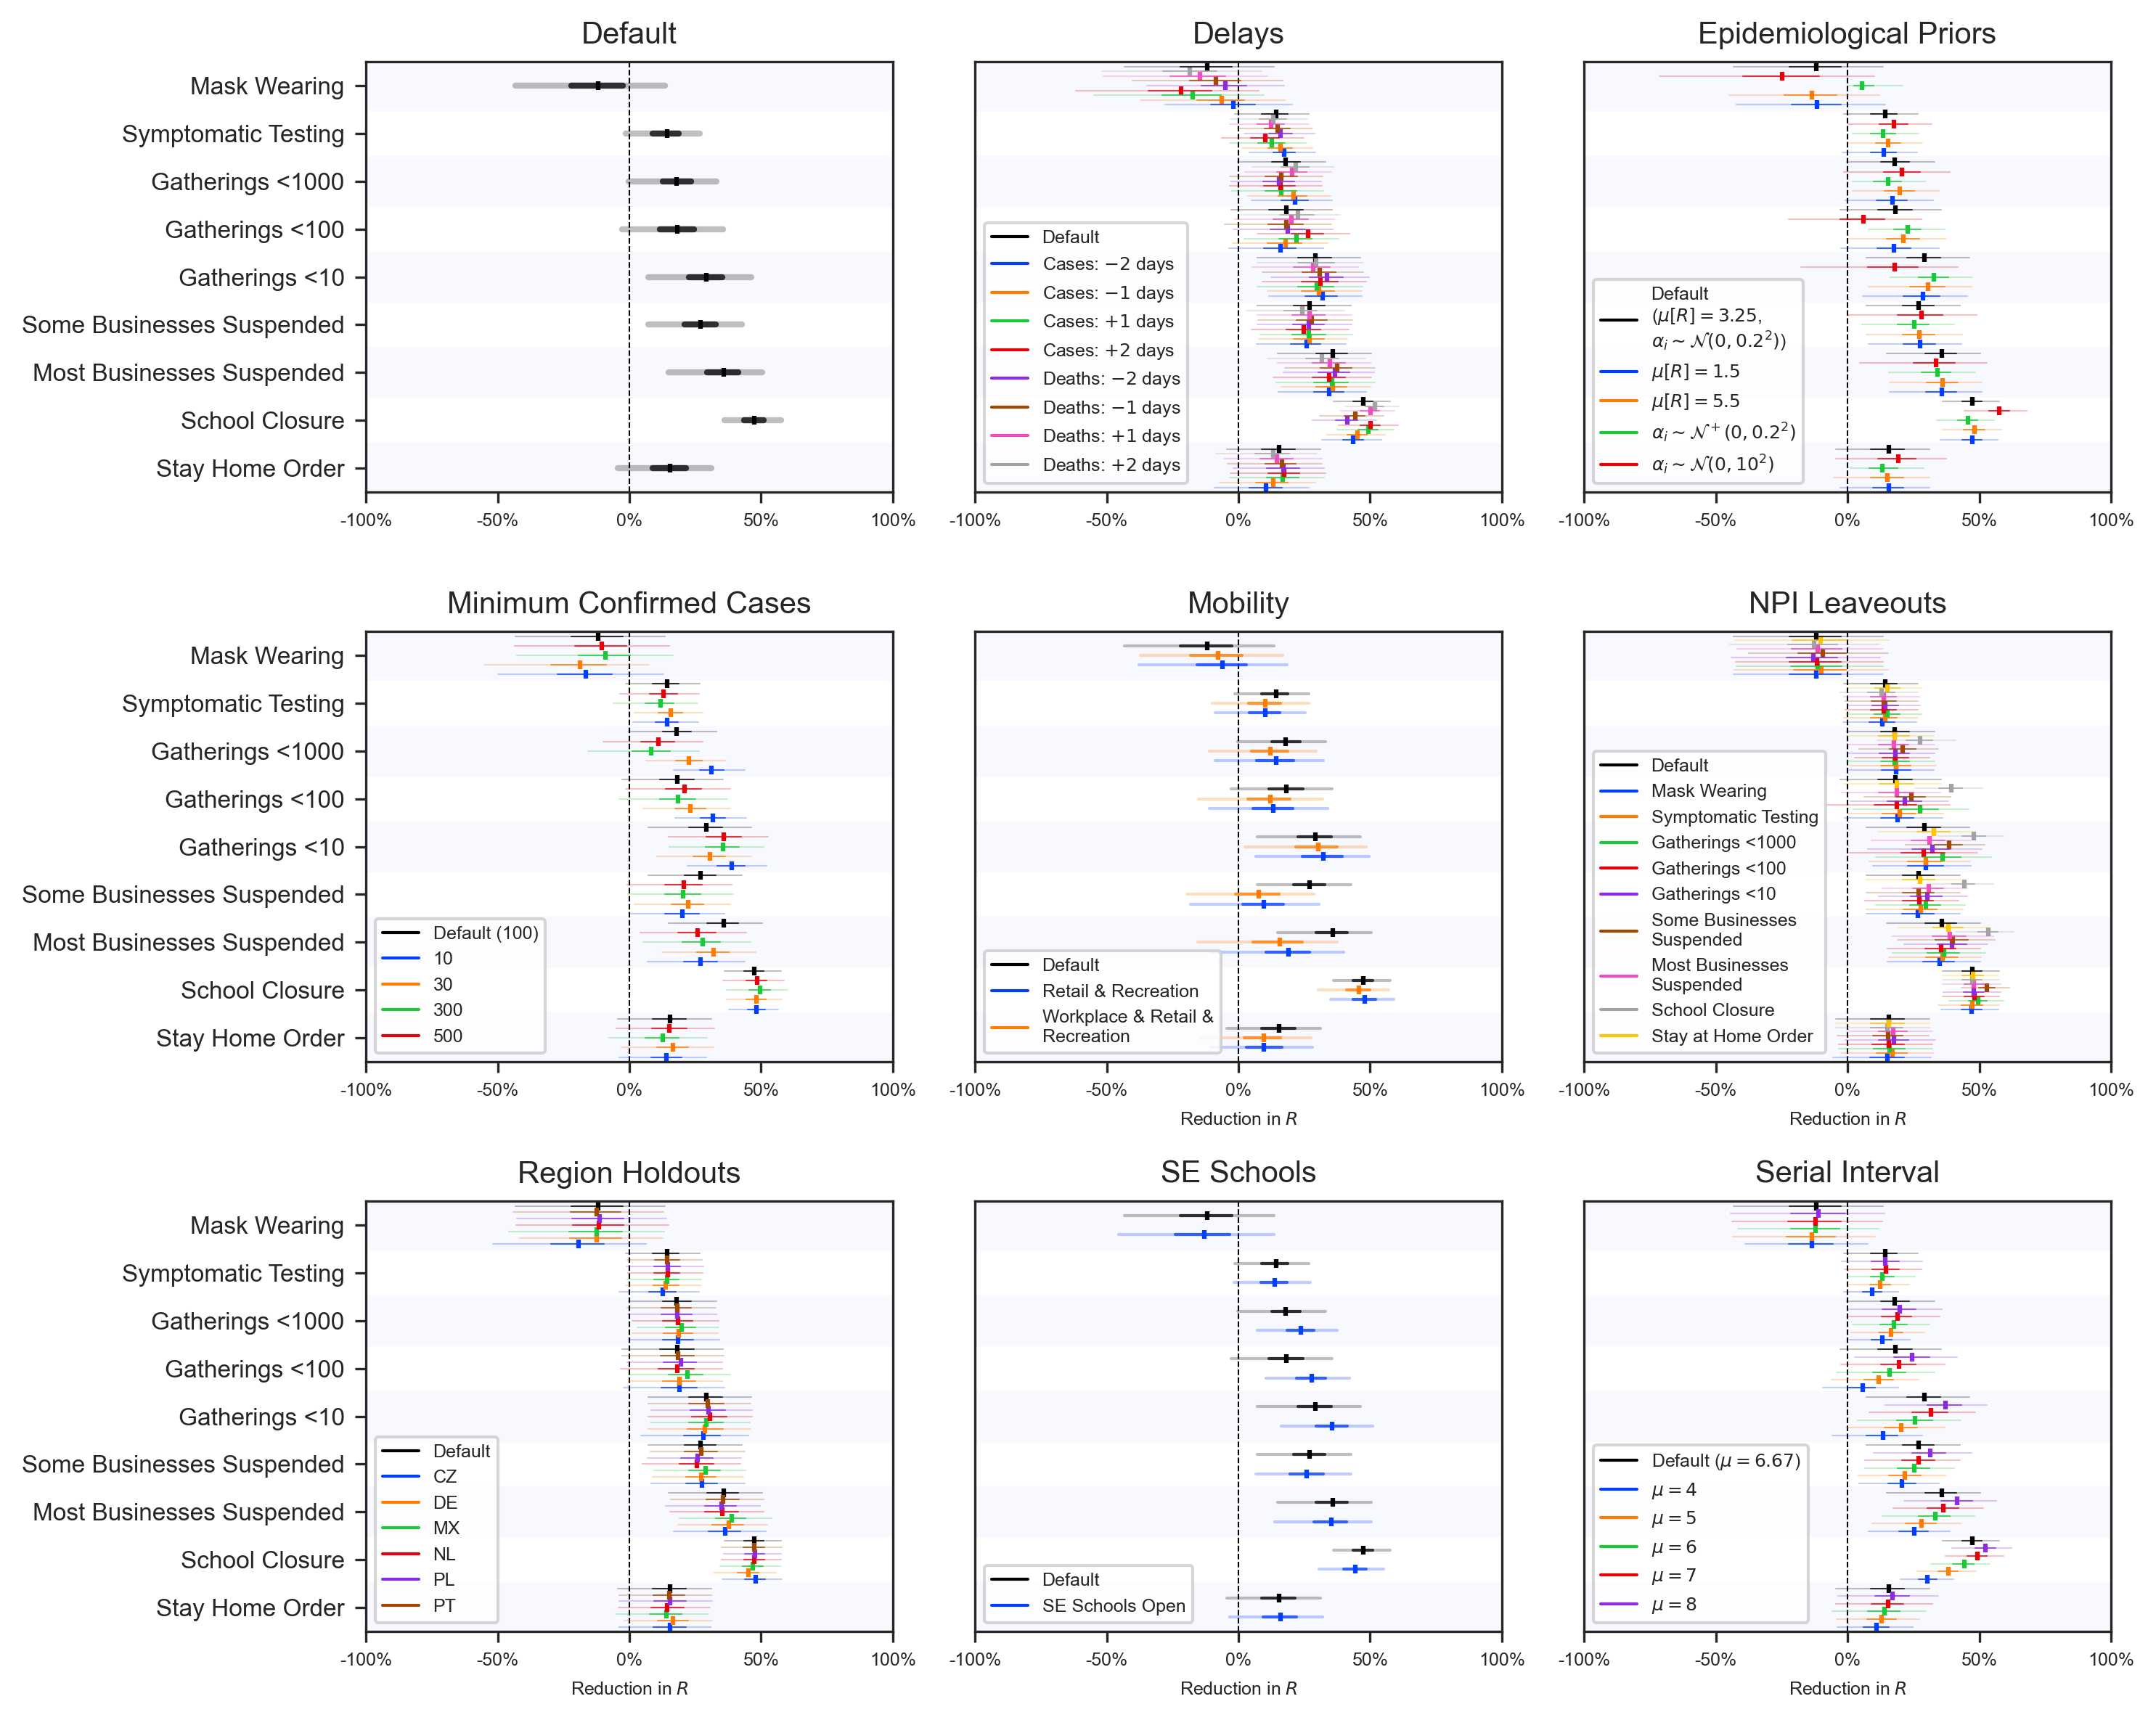

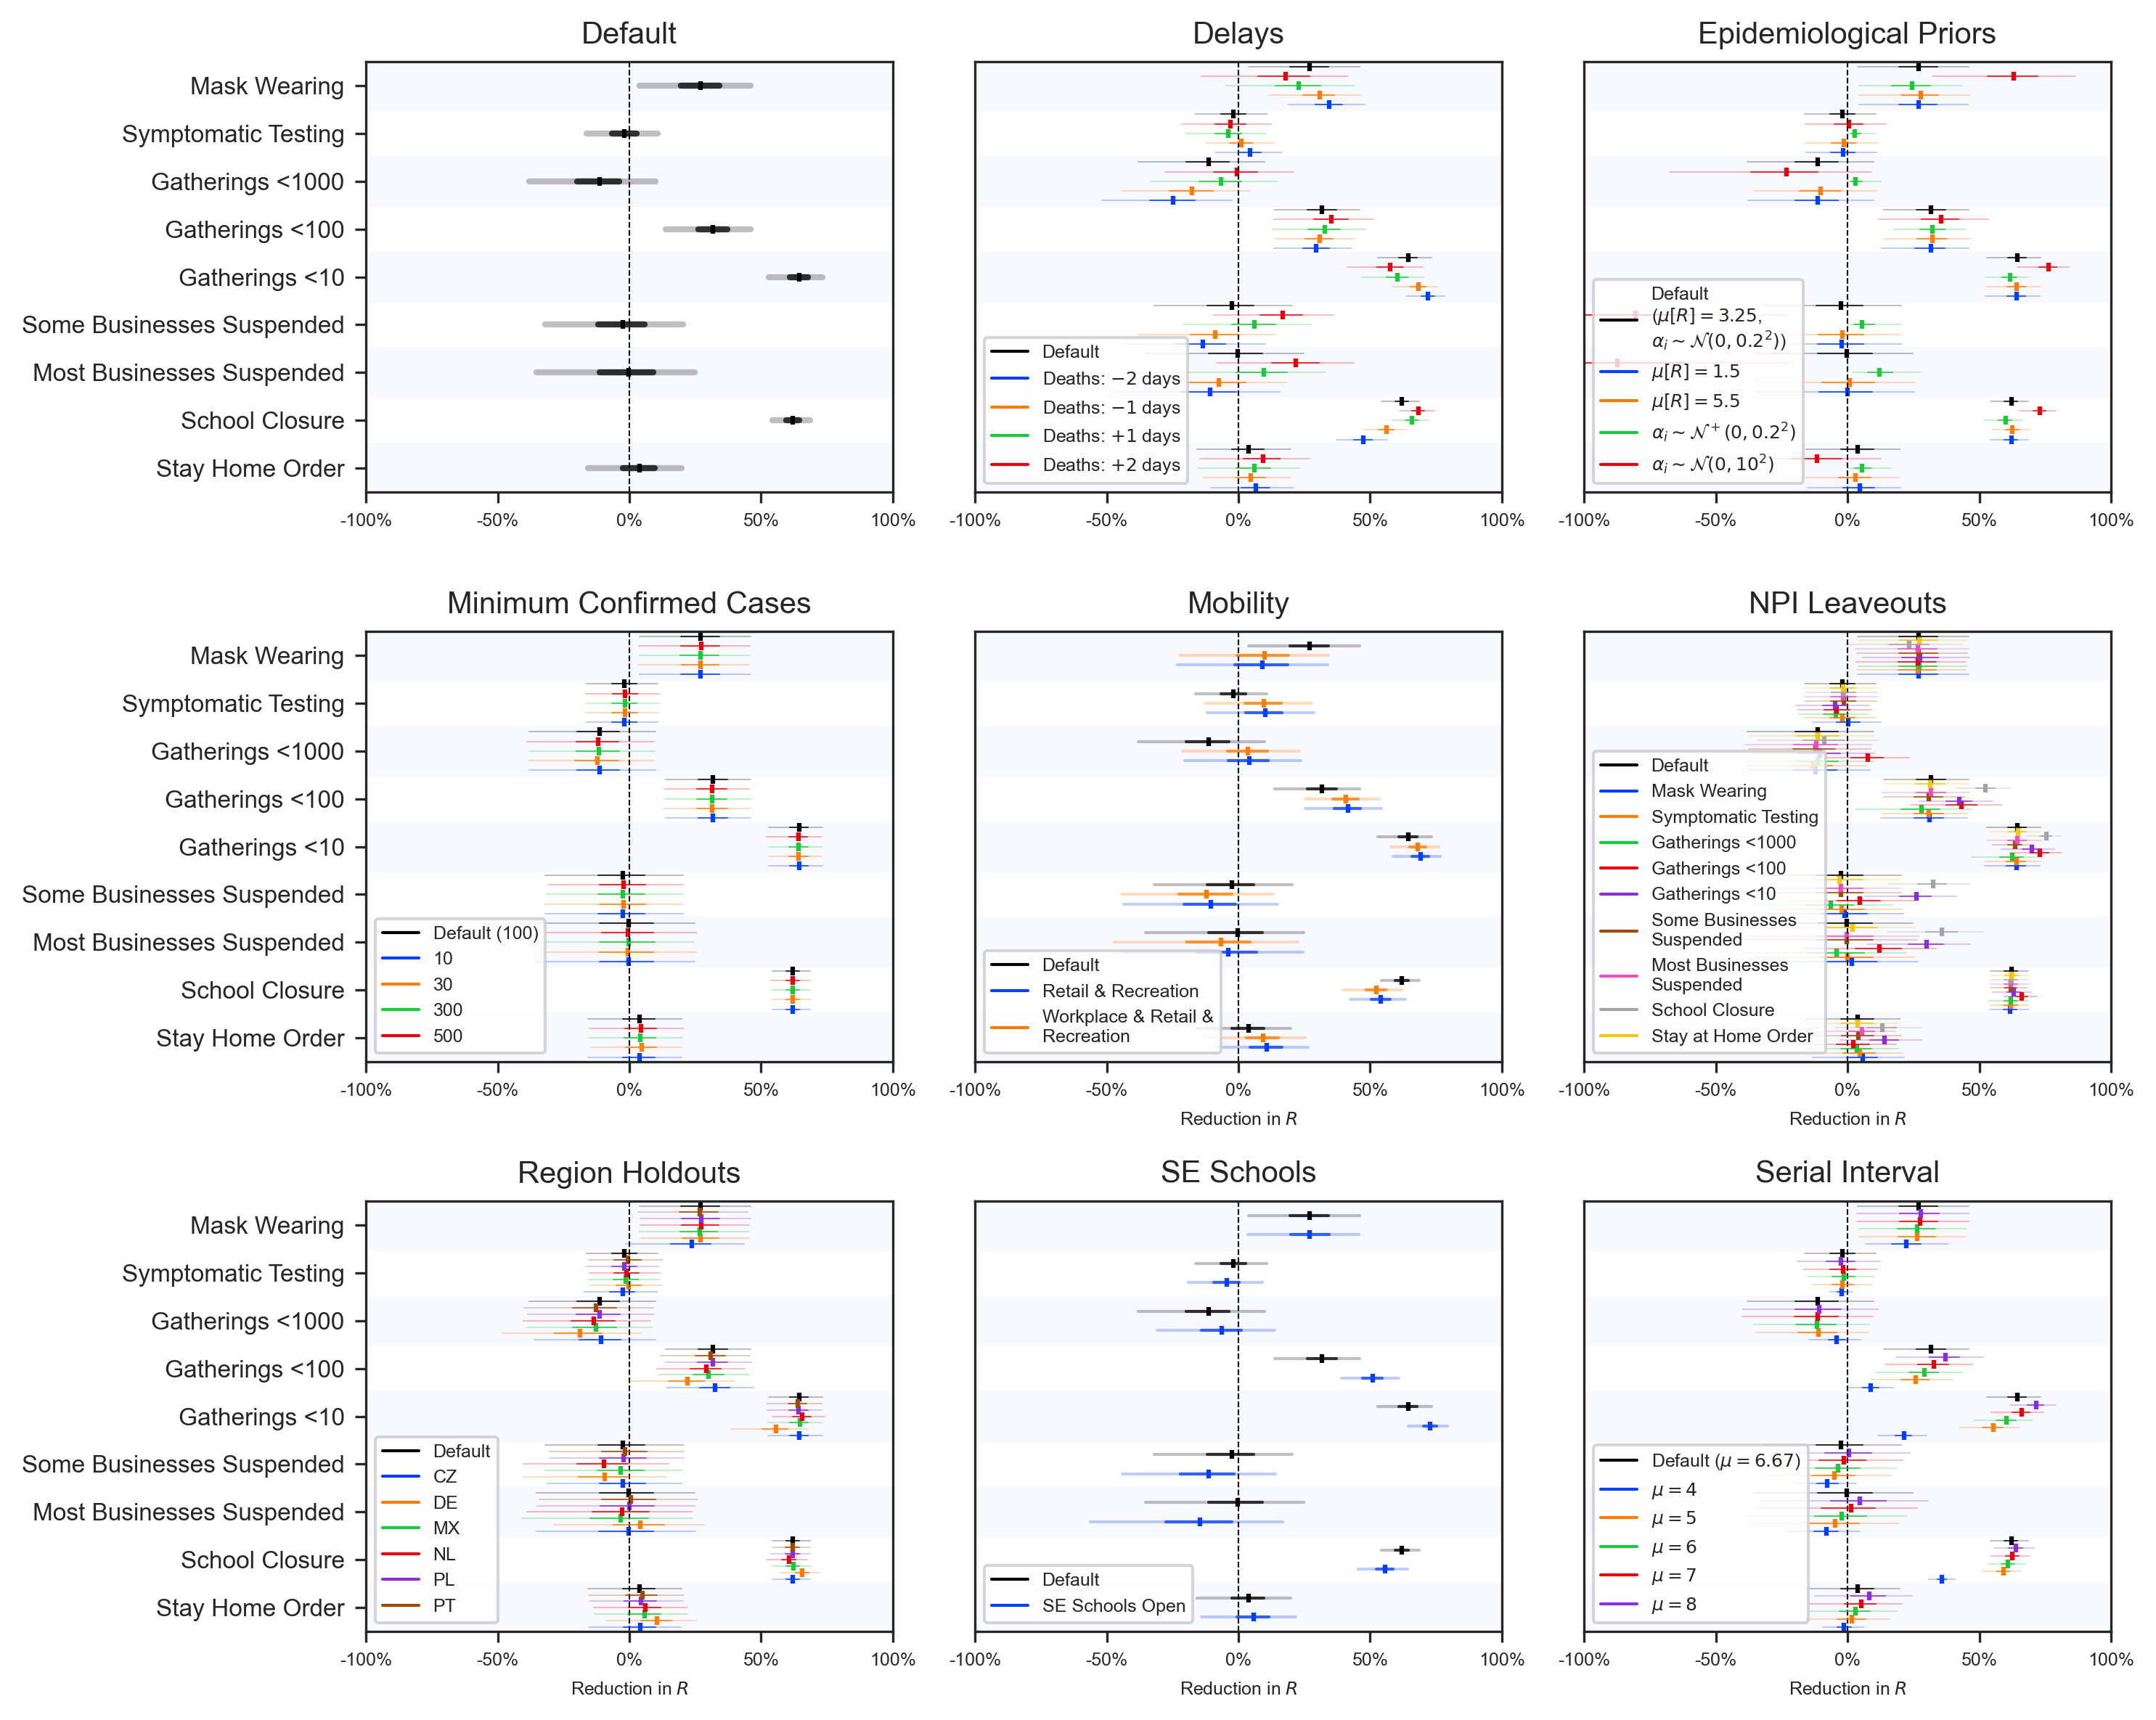

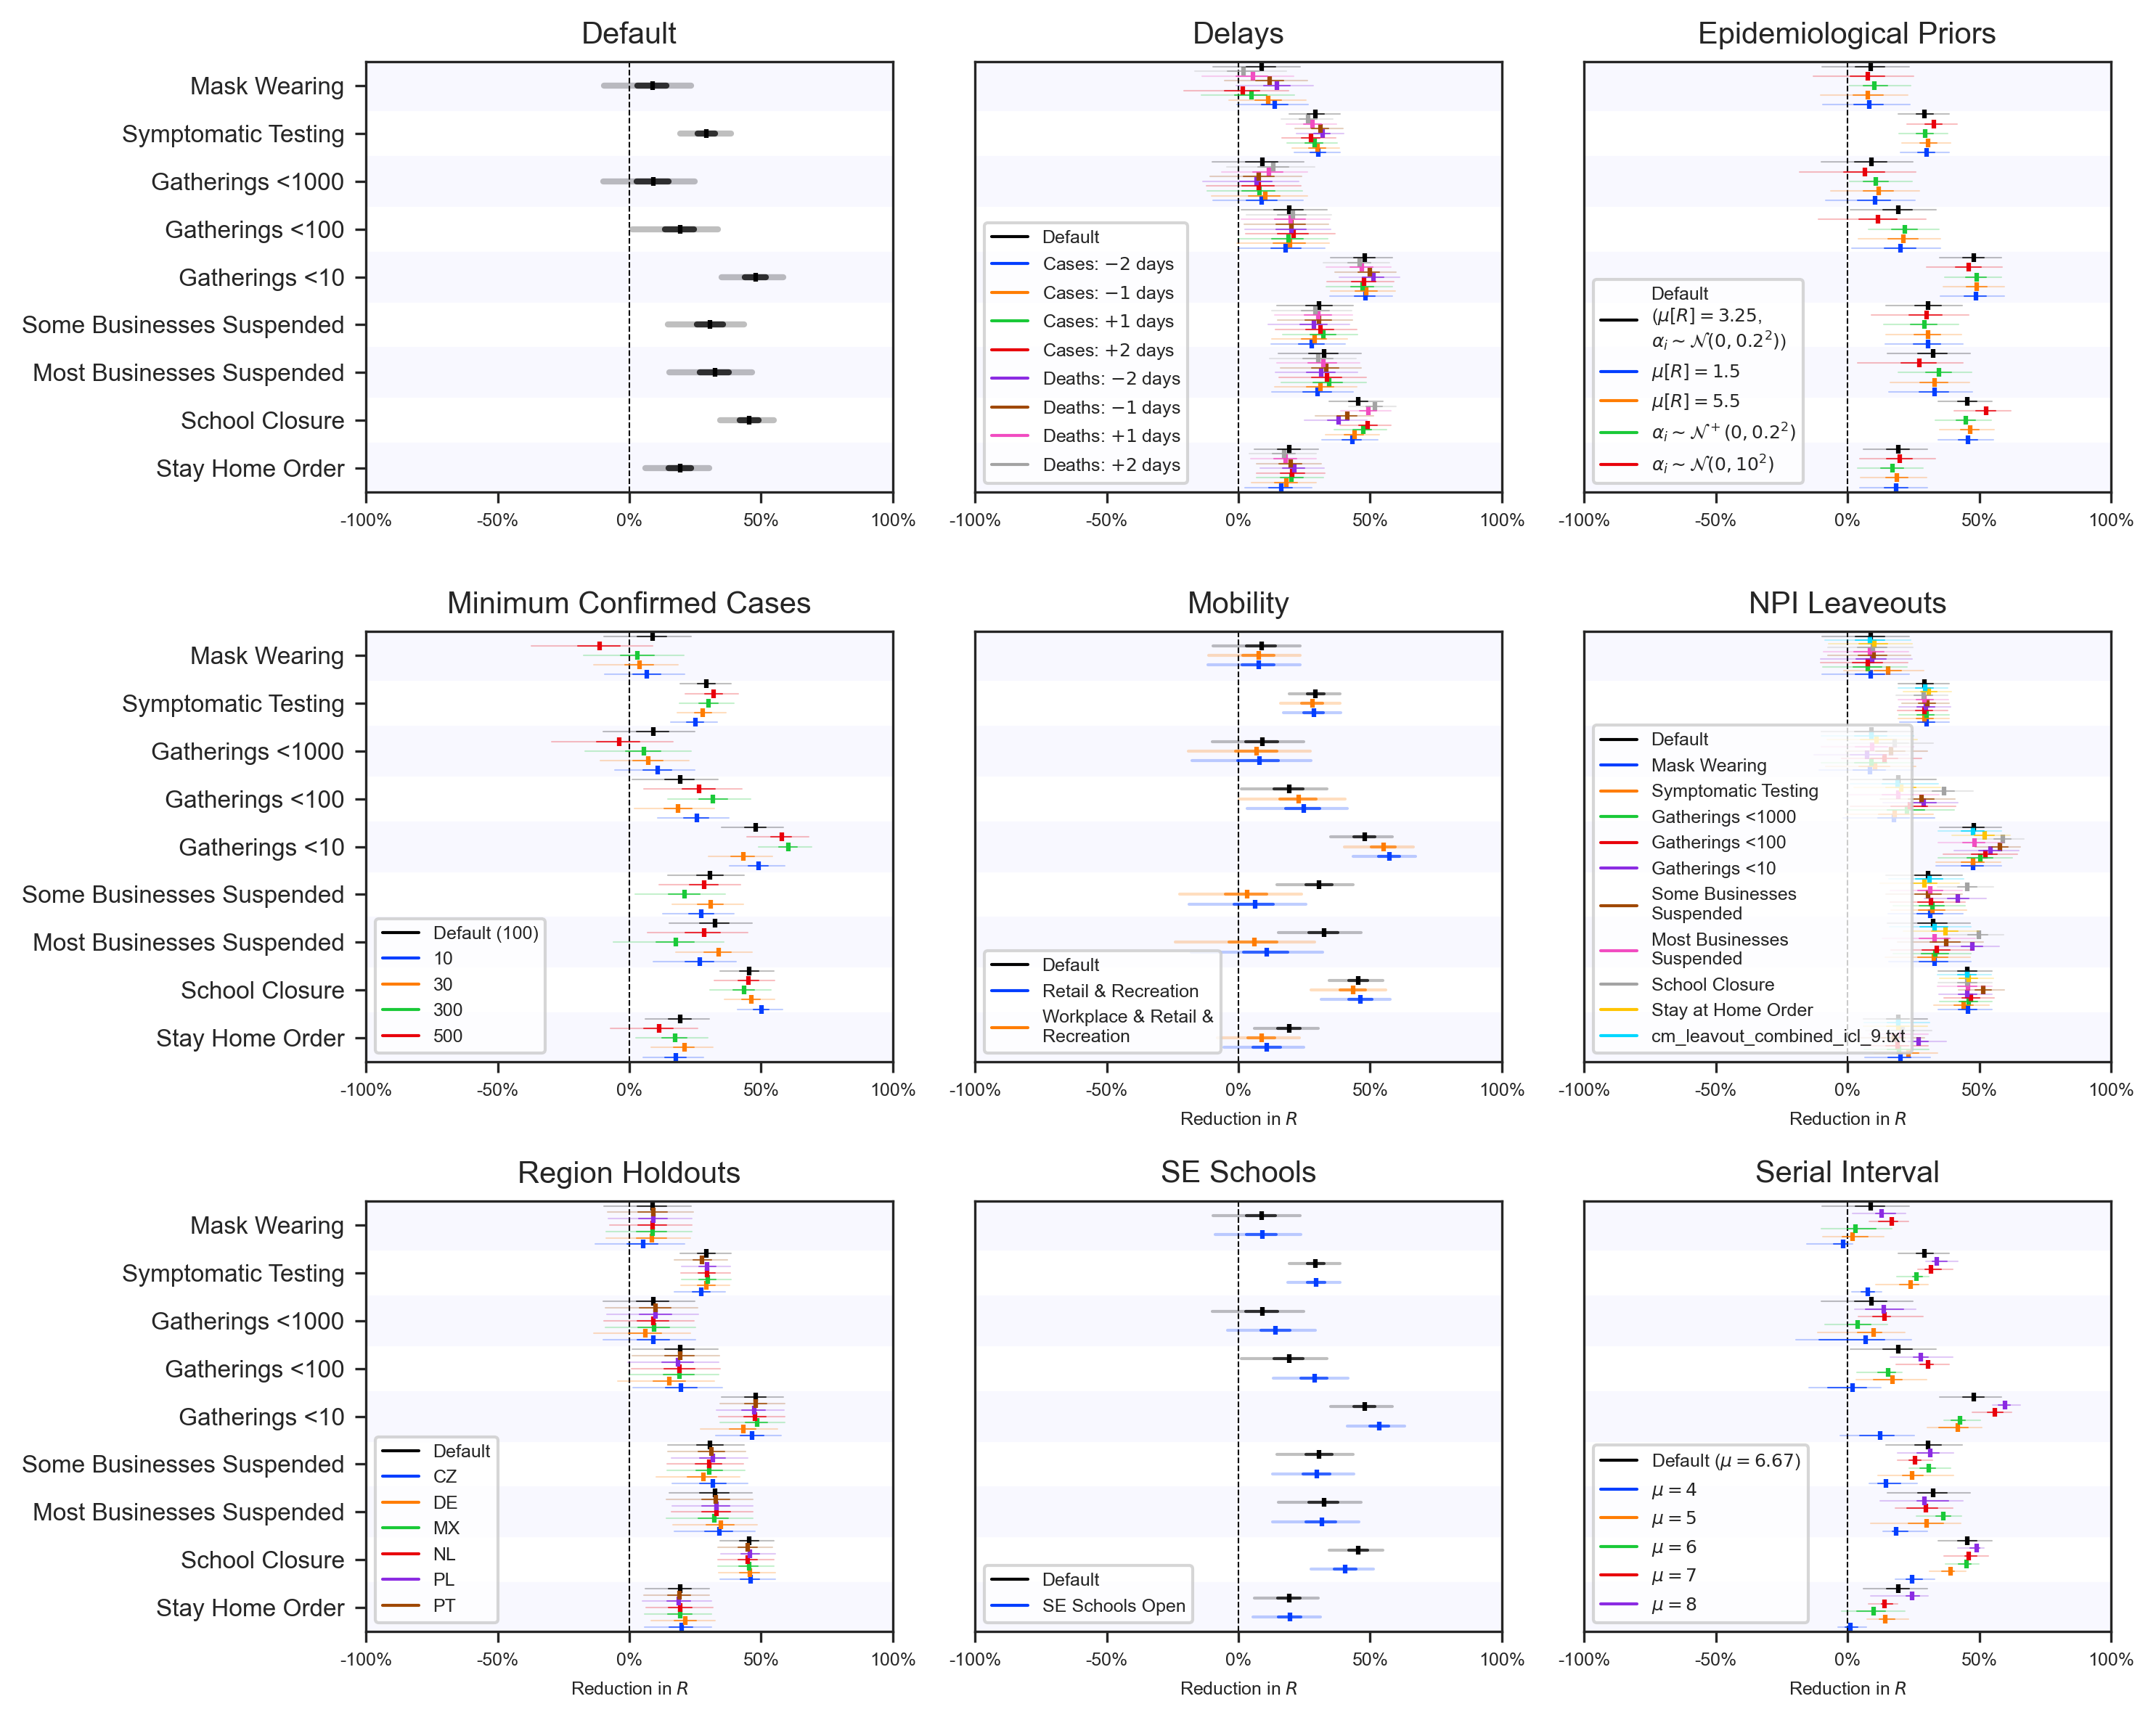

In [159]:
to_plot = ["baseline", "additive", "noisy-r7", "diff_effects", "icl_close", "ICL-Variant"]

[create_sensitivity_summary_plot(p) for p in to_plot]